<a href="https://colab.research.google.com/github/summerbulgaris/VolleyballTabular/blob/main/Volleyball_Tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import matplotlib
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

     |████████████████████████████████| 720 kB 14.3 MB/s 
     |████████████████████████████████| 62 kB 729 kB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 1.2 MB 30.7 MB/s 
     |████████████████████████████████| 189 kB 50.2 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 257 kB/s 


In [ ]:
path = "/content/kovo-male.csv"

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.columns

Index(['Share_Variance', 'Attack_Variance', 'Open%', 'Open_SR', 'Delay%',
       'Delay_SR', 'Move%', 'Move_SR', 'Back%', 'Back_SR', 'Quick%',
       'Quick_SR', 'Quickopen%', 'Quickopen_SR', 'Serve_SR', 'Dig_SR',
       'Set_SR', 'Receive_Accuracy', 'Receive_Variance', 'Blocking_SR',
       'Blocking_ER', 'Blocking_AR', 'Penalty', 'Error', 'Outcome'],
      dtype='object')

In [ ]:
dep_var = 'Outcome'

In [ ]:
df[dep_var]

0       0
1       1
2       1
3       0
4       1
       ..
3881    1
3882    1
3883    0
3884    1
3885    0
Name: Outcome, Length: 3886, dtype: int64

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
splits = ([i for i in range(0,2240)],[i for i in range(2240,2340)])

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(2240, 100)

In [ ]:
to.show(3)

,Delay_SR_na,Move_SR_na,Quickopen_SR_na,Share_Variance,Attack_Variance,Open%,Open_SR,Delay%,Delay_SR,Move%,Move_SR,Back%,Back_SR,Quick%,Quick_SR,Quickopen%,Quickopen_SR,Serve_SR,Dig_SR,Set_SR,Receive_Accuracy,Receive_Variance,Blocking_SR,Blocking_ER,Blocking_AR,Penalty,Error,Outcome
0,True,False,True,220.693878,802.250000,58.156029,53.658535,0.000000,60.000000,6.382979,66.666664,13.475178,47.368420,21.985815,35.483871,0.0,55.555557,1.960784,81.666664,50.364964,66.666664,234.925613,24.444445,0.0,0.0,0,22,0
1,False,False,True,173.959183,569.888916,51.470589,45.714287,5.147059,57.142857,4.411765,66.666664,13.970589,52.631580,25.000000,47.058823,0.0,55.555557,0.943396,78.571426,47.727272,67.021278,224.024689,34.615383,0.0,0.0,0,18,1
2,False,False,True,87.654320,589.138916,66.355141,54.929577,3.738318,25.000000,8.411215,55.555557,6.542056,57.142857,14.953271,56.250000,0.0,55.555557,2.105263,80.392159,52.427185,72.602737,105.909721,23.809525,0.0,0.0,0,18,1


In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

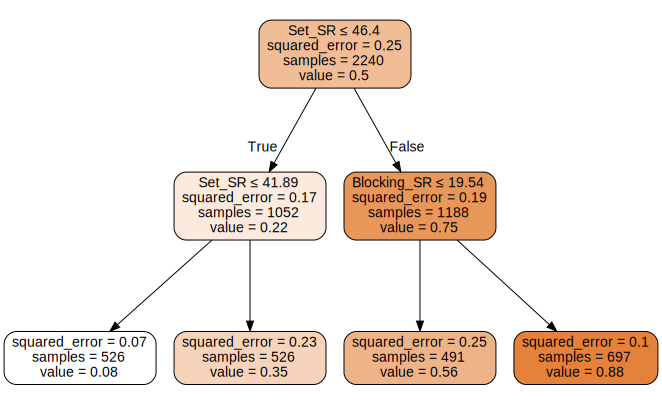

In [ ]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


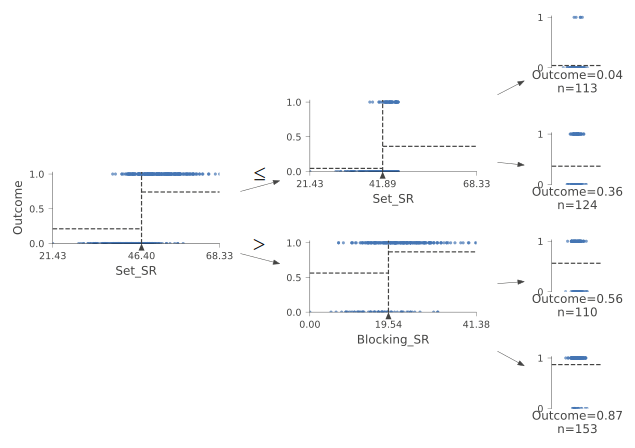

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
  fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
  orientation='LR')

In [ ]:
def sigmoid(x):
  if x>=0.5:
    return 1
  else:
    return 0

sigmoid_v = np.vectorize(sigmoid)

def r_mse(pred,y): 
  pred = sigmoid_v(pred)
  return ((pred-y)**2).mean()
  
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);
m_rmse(m, valid_xs, valid_y)

0.23

In [ ]:
m_rmse(m, xs, y)

0.0

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.23

In [ ]:
m.get_n_leaves(), len(xs)

(242, 2240)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.1419642857142857, 0.17)

In [ ]:
m.get_n_leaves()

48

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=2211,
  max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
  max_samples=max_samples, max_features=max_features,
  min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.03660714285714286, 0.19)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [ ]:
r_mse(preds.mean(0), valid_y)

0.19

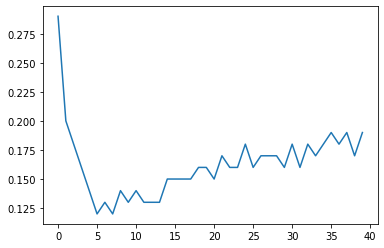

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [ ]:
r_mse(m.oob_prediction_, y)

0.171875

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [ ]:
preds.shape

(40, 100)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.10420207, 0.34308863, 0.35447841, 0.3305628 , 0.38547904])

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
19,Set_SR,0.329207
22,Blocking_SR,0.122539
6,Open_SR,0.088433
18,Dig_SR,0.074989
24,Blocking_AR,0.044111
...,...,...
10,Move_SR,0.004683
1,Move_SR_na,0.000951
2,Quickopen_SR_na,0.000000
25,Penalty,0.000000


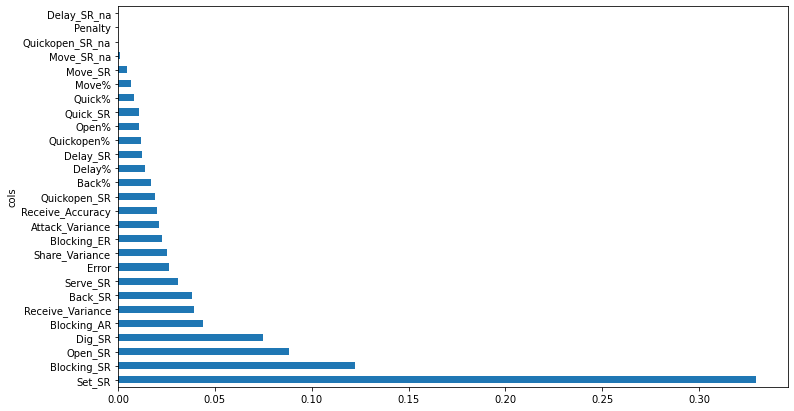

In [ ]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.03794642857142857, 0.16)

In [ ]:
len(xs.columns), len(xs_imp.columns)

(27, 22)

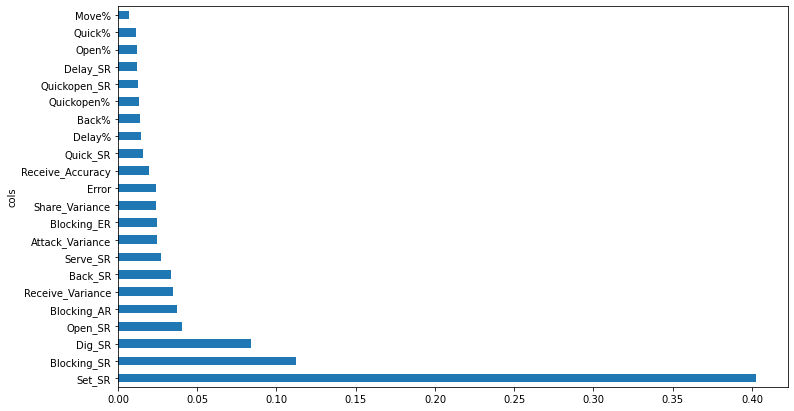

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

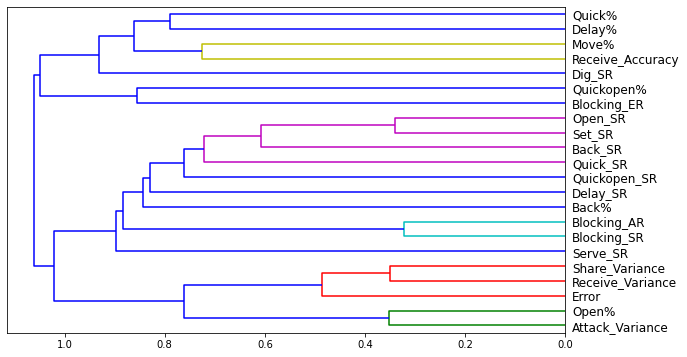

In [ ]:
cluster_columns(xs_imp)